In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
from read_hdf5 import read_hdf5_convolution

%load_ext watermark
%watermark -iv -vg

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.17.2

Git hash: 0fc665ac2546c760942afe9bba0d3bf69d56494d

pocomc    : 0.2.4
matplotlib: 3.8.1
numpy     : 1.26.1



In [2]:
NBINS = 8

### Load data

['ant_temp', 'freq', 'lst']


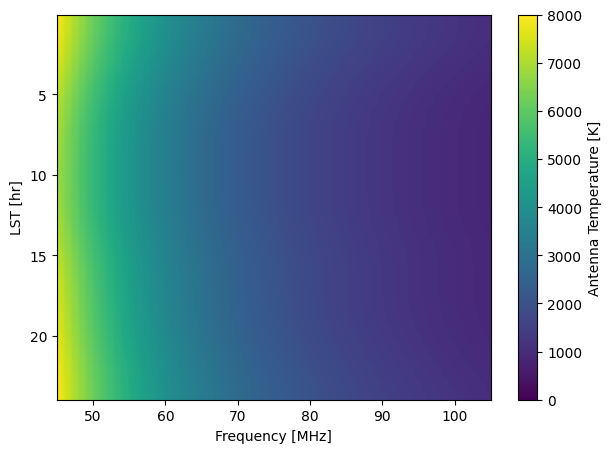

In [3]:
lst, freq, temp = read_hdf5_convolution(
    "simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

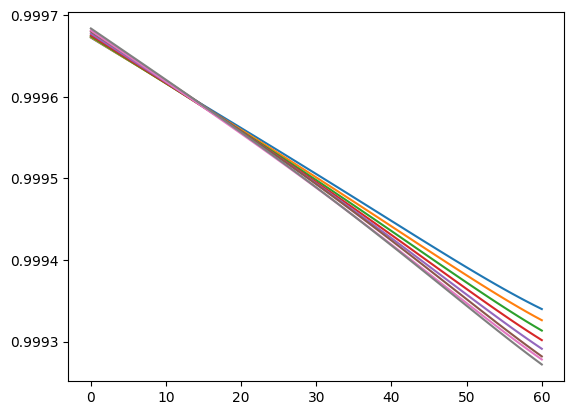

In [4]:
fg_bin = temp[:-(nspec%NBINS)].reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure()
plt.plot(fg_bin.T/fg_mean[:, None])
plt.show()

### Foreground model

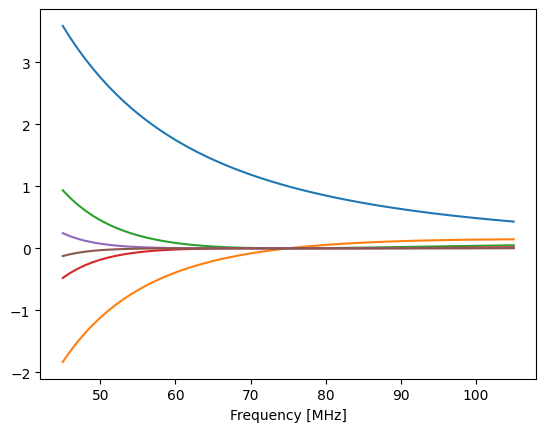

In [5]:
def design_mat(freq, nfg=5, beta=-2.5, nu_fg=75):
    """
    Generate a matrix of shape (Nfreq, Nfg) that evaluates the linlog model given a vector of foreground parameters.

    Parameters
    ----------
    freq : np.ndarray
        Frequencies to evaluate the model at.
    nfg : int
        Number of foreground terms.
    beta : float
        Spectral index of power law.
    nu_fg : float
        Normalization frequency in same units as freq.

    Returns
    -------
    A : np.ndarray
        The design matrix, i.e., a matrix with the linlog basis functions as the columns.
    
    """
    f_ratio = freq[:, None]/nu_fg  # dimensionless frequency ratio
    powers = np.arange(nfg)[None]
    A = f_ratio**beta * np.log(f_ratio)**powers
    return A

A = design_mat(freq, nfg=6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

In [6]:
class LSTBin:
    def __init__(self, freq, spec, noise_std, injected_t21, nfg=None):
        """
        Class for a LST bin, holding a spectrum, noise, design matrix and necessary covariance matrices.

        Parameters
        -----------
        freq : np.ndarray
            The frequency array corresponding to the spectrum.
        spec : np.ndarray
            The spectrum at the given LST bin.
        noise_std : np.ndarray
            The standard deviation of the noise to inject at each frequency channel.
        injected_t21 : np.ndarray
            The injected 21cm signal. An array of temperature values, same length as ``freq''.
        nfg : int
            Number of foreground parameters to fit. If None, will be determined by minimizing BIC in compute_nfg().
        
        """
        self.freq = freq
        self.spec = spec.copy()
        self.noise_std = noise_std
        self._noise_added = False
        self.add_noise()
        self.sigma = np.diag(self.noise_std**2)
        self.sigma_inv = np.diag(1/self.noise_std**2)
        self.injected_t21 = injected_t21
        if nfg is None:
            self.compute_nfg()
        else:
            self.nfg = nfg
            self.A = design_mat(self.freq, nfg=self.nfg)    
        self.compute_covs()
         
    def add_noise(self):
        if self._noise_added:
            return
        noise = rng.normal(scale=self.noise_std)
        self.spec += noise
        self._noise_added = True

    def compute_nfg(self, nfg_min=1, nfg_max=10):
        """
        Use the BIC to determine the number of foreground parameters
        """
        test_nfg = np.arange(nfg_min, nfg_max+1)
        min_bic = np.nan  # initialize the min bic
        for n in test_nfg:
            A = design_mat(self.freq, nfg=n)
            residuals = fg_mle(self.spec, A, self.sigma_inv, self.injected_t21, 0)[1]  # XXX
            bic = np.sum(residuals**2) + n*np.log(self.freq.size)
            if np.isnan(min_bic) or bic < min_bic:
                self.nfg = n
                self.A = A
                min_bic = bic
        print(f"nfg = {self.nfg}")

    def compute_covs(self):
        """Compute necessary covariance matrices"""
        if not self._noise_added:
            raise ValueError("Cannot compute covariances without noise")  #XXX some other error probably
        
        Cinv = self.A.T @ self.sigma_inv @ self.A
        self.C = np.linalg.inv(Cinv)
        self.sigma_fg = self.A @ self.C @ self.A.T
        V = np.linalg.inv(np.linalg.inv(self.sigma_fg) - self.sigma_inv)
        self.C_total_inv = np.linalg.inv(self.sigma + V)


    def bin_fg_mle(self, model_t21):
        return fg_mle(self.spec, self.A, self.sigma_inv, self.injected_t21, model_t21)
        

def fg_mle(spec, A, sigma_inv, true_t21, model_t21):
    """
    Compute MLE foreground parameters given a foreground spectrum, a design matrix, an inverse noise covariance matrix, 
    an injected (true) 21cm signal and a model 21cm signal.

    Parameters
    ----------
    spec : np.ndarray
        The foreground spectrum.
    A : np.ndarray
        The design matrix of the foreground model.
    sigma_inv : np.ndarray
        The inverse noise covariance matrix.
    true_t21 : np.ndarray
        The injected 21cm signal.
    model_t21 : np.ndarray
        The assumed model of the 21cm signal.

    Returns
    -------
    theta_hat : np.ndarray
        The MLE foreground parameters.
    dstar : np.ndarray
        The residual spectrum after subtracting the 21cm model and best-fit foregrounds from the total
        time_bin + injected 21cm spectrum.
    
    """
    d = spec + true_t21
    r = d - model_t21
    C = np.linalg.inv(A.T @ sigma_inv @ A)
    theta_hat = C @ A.T @ sigma_inv @ r
    dstar = r - A @ theta_hat  # eq 8 in Monsalve 2018
    return theta_hat, dstar

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [7]:
rng = np.random.default_rng(seed=1913)  # initialize random number generator
noise_75 = 3e-3
noise_std = noise_75 * (fg_bin/fg_mean[freq==75]) * np.sqrt(nspec/(nspec//NBINS))  # radiometer equation
noise_mean_std = noise_75 * (fg_mean/fg_mean[freq==75])

### Global signal

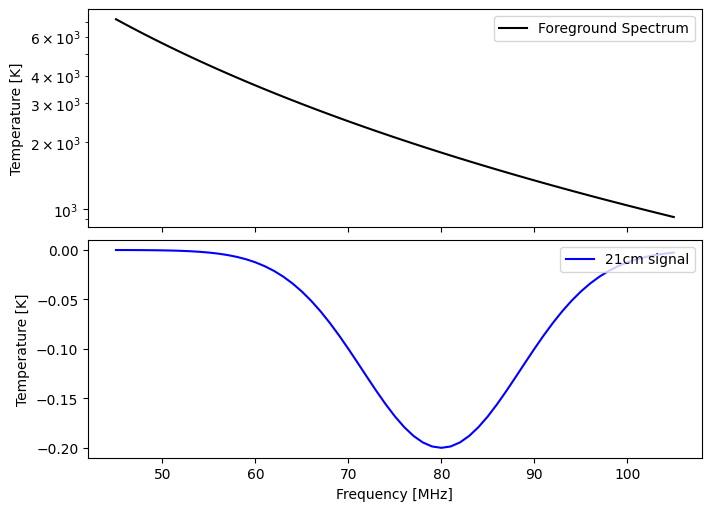

In [8]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Initialize and run sampler

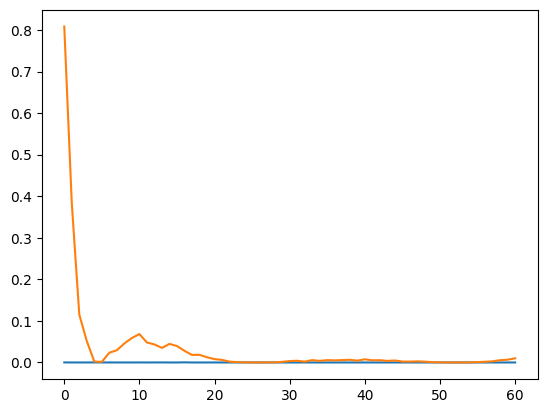

In [9]:
lst_bins = [LSTBin(freq, fg_bin[i], noise_std[i], TRUE_T21) for i in range(NBINS)]
lst24h = LSTBin(freq, fg_mean, noise_mean_std, TRUE_T21, nfg=6)

r_mean = lst24h.bin_fg_mle(TRUE_T21)[1]
r_bin = lst_bins[0].bin_fg_mle(TRUE_T21)[1]
plt.figure()
plt.plot(r_mean**2)
plt.plot(r_bin**2)
plt.show()

In [10]:
def log_prior(params, bounds):
    """
    Uniform priors on all parameters.
    """
    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0

# Parameter bounds (a, w, nu21)
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
n_dim = len(bounds)

def _log_likelihood_1spec(params, lst_bin):
    """
    The log likelihood for one spectrum.
    """
    t21_model = gauss(freq, *params)
    dstar = lst_bin.bin_fg_mle(t21_model)[1]
    return -1/2 * dstar.T @ lst_bin.C_total_inv @ dstar

def log_likelihood(params, lst_bins):
    if isinstance(lst_bins, LSTBin):  # 1 bin only, not a list
        return _log_likelihood_1spec(params, lst_bins)
    lnL = 0
    for lst_bin in lst_bins:
        lnL += _log_likelihood_1spec(params, lst_bin)
    return lnL
    

n_particles = 1000
prior_samples = rng.uniform(size=(n_particles, n_dim), low=bounds.T[0], high=bounds.T[1])

In [11]:
log_like_args = [lst_bins]

sampler = pc.Sampler(
    n_particles,
    n_dim,
    log_likelihood,
    log_prior,
    bounds=bounds,
    log_likelihood_args=log_like_args,
    log_prior_args=[bounds],
)
sampler.run(prior_samples)
results = sampler.results

Iter: 17it [01:19,  6.38s/it, beta=0.00257, calls=39000, ESS=0.95, logZ=-18.3, accept=0.215, N=3, scale=0.966, corr=0.704]  /home/christian/Documents/research/MIST/global_signal/.venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 54it [05:18,  5.91s/it, beta=1, calls=126000, ESS=0.948, logZ=-4.24e+3, accept=0.248, N=2, scale=1.18, corr=0.683]    


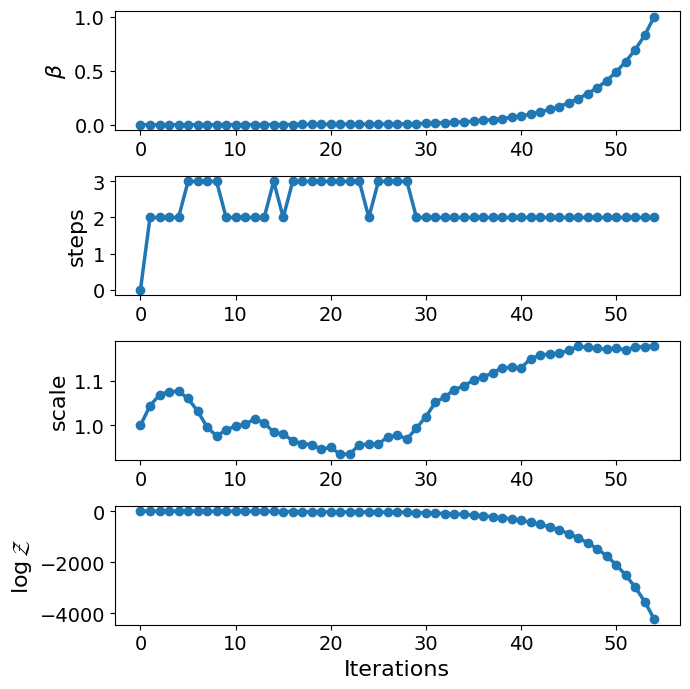

In [12]:
_ = pc.plotting.run(results, width=7, height=7)

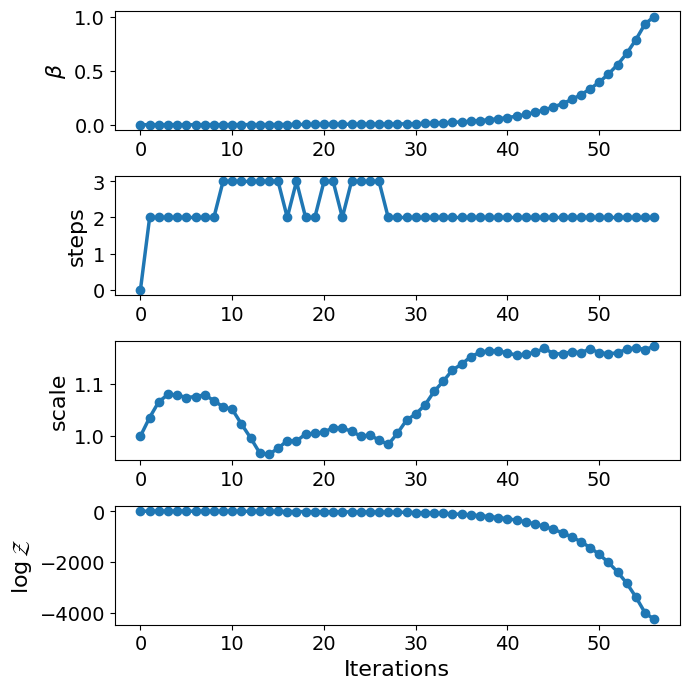

In [12]:
_ = pc.plotting.run(results, width=7, height=7)  #old!

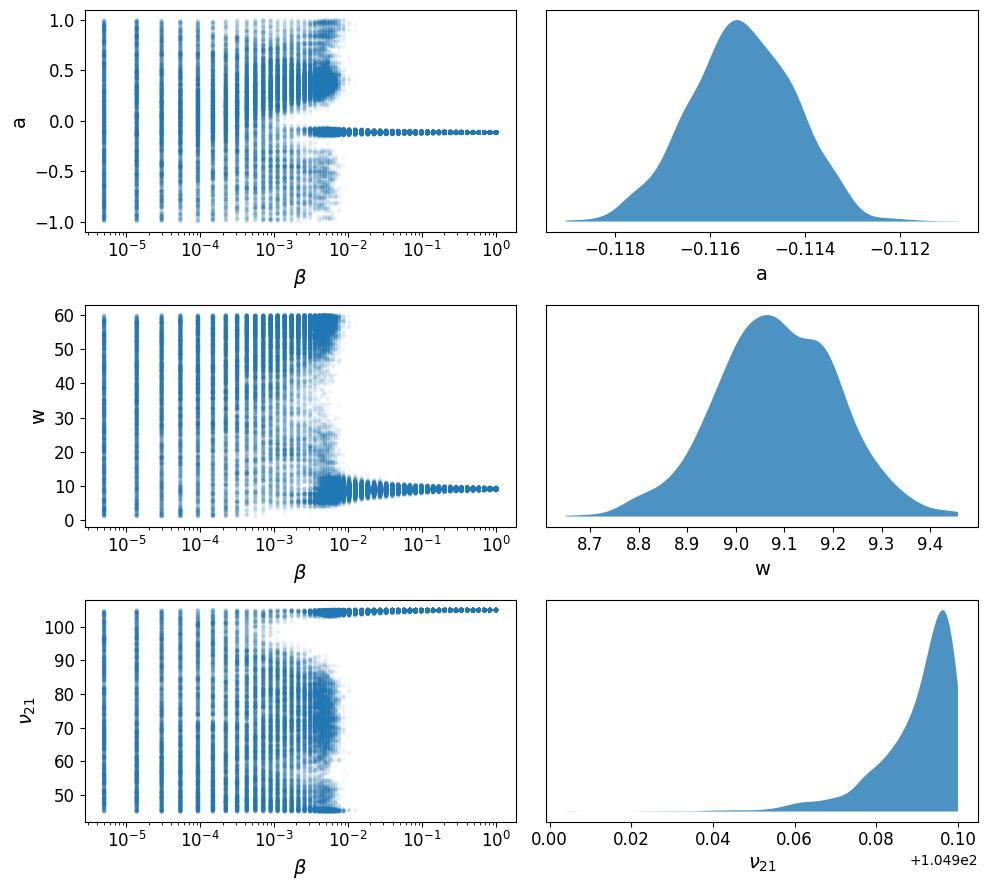

In [13]:
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)

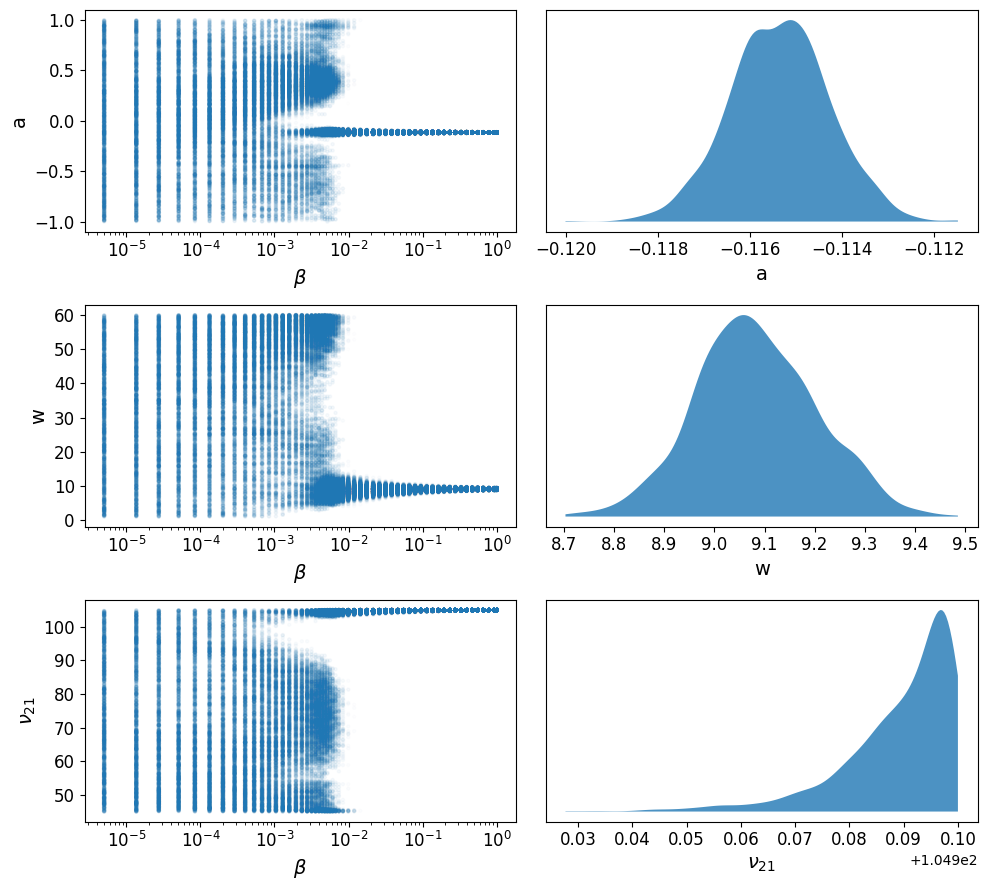

In [13]:
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)  #OLD

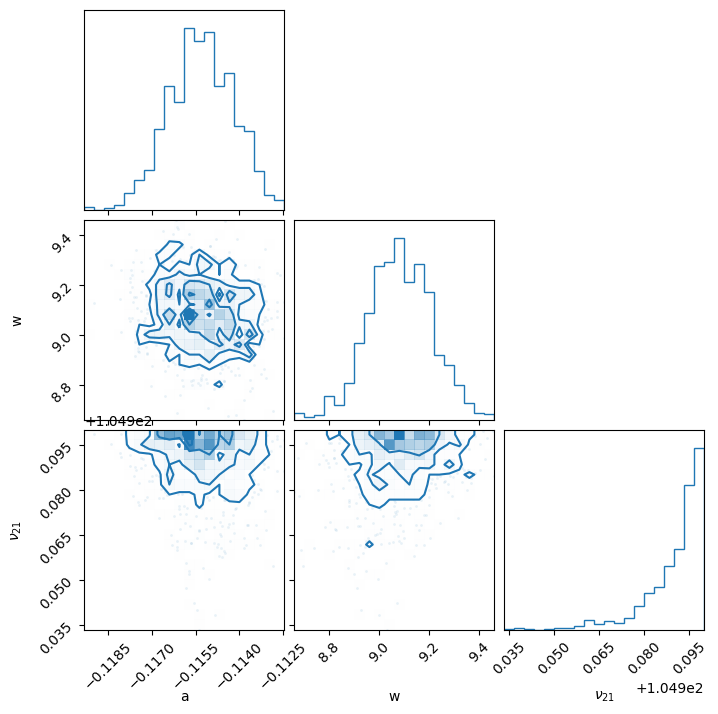

In [14]:
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

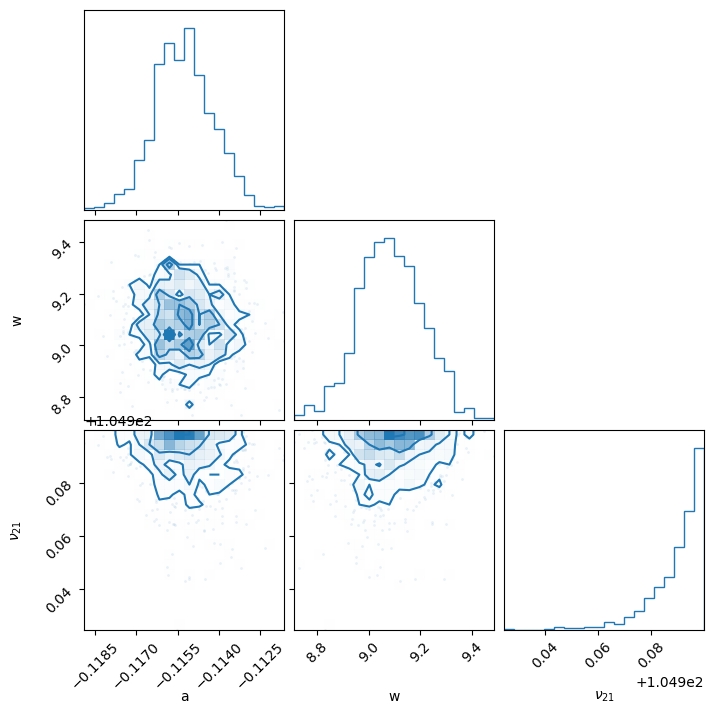

In [14]:
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")  #OLD